# Get Our Initial Data

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2



vid_name='relax'
filename='/Users/henryschnieders/Documents/Research/My_work/Real_time_recognition/All_face_sections/amplitude_heatmap/Each_pixel/Pixel_matching_methods/Template_Matching/Data/relax_tempmatch.npy'


data=np.load(filename, allow_pickle=True)
data=data[:-5]

pix_intensity=[frame[0,0] for frame in data]

FileNotFoundError: [Errno 2] No such file or directory: '/Users/henryschnieders/Documents/Research/My_work/Real_time_recognition/All_face_sections/amplitude_heatmap/Each_pixel/Pixel_matching_methods/Template_Matching/Data/relax_tempmatch.npy'

In [1]:
#fps-from

vid_path='/Users/henryschnieders/documents/Research/My_work/Data/sporting_1.mp4'
def get_frames(video_path, desired_frames=2000):
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)

    # Initialize an empty list to store frames
    frames = []

    # Frame processing loop
    frame_count = 0
    while cap.isOpened() and frame_count < desired_frames:
        ret, frame = cap.read()
        if not ret:
            break
        
        # Resize frame to the desired dimensions
        #frame_resized = cv2.resize(frame, (desired_dimensions, desired_dimensions))

        
        # Add the frame to the list
        frames.append(frame)
        
        frame_count += 1

    # Release the video capture object
    cap.release()

    return fps

fps=get_frames(vid_path)
fps


NameError: name 'cv2' is not defined

In [4]:
import pywt
from scipy.signal import butter, filtfilt, find_peaks

In [5]:
def complex_mag(arr):
    return np.absolute(arr)

In [6]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5, padlen=14):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data, padlen=padlen)
    return y

[-17.67871236+11.56370227j   7.79462111+20.70431373j
   7.79462111-20.70431373j  16.09893538-32.38244915j
  16.09893538+32.38244915j]


[ 1.59676389 -1.35110791  1.35110791 -1.22827992  1.22827992]
bpm FFT = 79.4567073477552


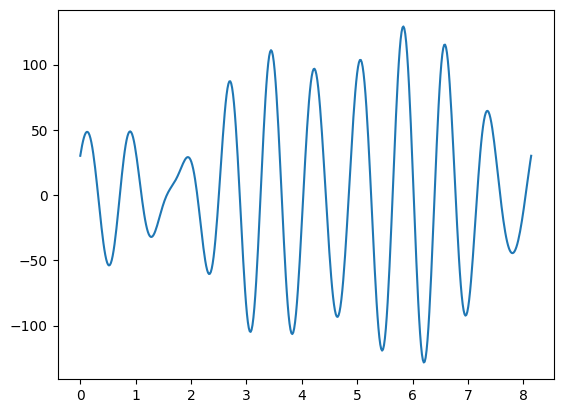

wavelt hear trate is 78.97507897507897
butterworth bandpass heart rate is 95.80583351075154
averaged heart rate is 1647.3944511170473


In [27]:

# # 1. 读取视频数据

#video_data=Amplitude
# 2. 通过人脸识别确定ROI

#w,h=video_data.shape[1],video_data.shape[2]
#x0,y0,x1,y1=0,0,w,h

# 定义滤波器参数
sampling_rate = fps # 95.2381  # 假设视频帧率为30帧每秒
# 提取心率和呼吸信号的频率范围
# 心率通常在 0.5 - 4 Hz
# 呼吸信号通常在 0.1 - 0.5 Hz
lowcut_heart = 1.0
highcut_heart = 3.0
#lowcut_breath = 0.3
#highcut_breath = 1.0

# 傅里叶变换
N = len(pix_intensity)  # 信号长度
T = 1.0 / sampling_rate  # 采样间隔
coefs = np.fft.fft(pix_intensity)  # 傅里叶变换
freqs = np.fft.fftfreq(N, T) # 获取频率



indices = np.where((np.abs(freqs) >= lowcut_heart) & (np.abs(freqs) <= highcut_heart))

coefsinrange=coefs[indices]
freqsinrange=freqs[indices]

max_indicies=np.argsort(complex_mag(coefsinrange))[-5:]
coefsinrange=coefsinrange[max_indicies]
freqsinrange=freqsinrange[max_indicies]



print(coefsinrange)
print("\n")
print(freqsinrange)
data=np.linspace(0, (1/fps)*len(pix_intensity), len(pix_intensity))


y_dat=[np.real(coefsinrange[i])*np.cos(2*np.pi*freqsinrange[i]*data)+np.imag(coefsinrange[i])*np.sin(2*np.pi*freqsinrange[i]*data) for i in range(len(coefsinrange))]


print(f'bpm FFT = {np.average(np.abs(freqsinrange)*60, weights=complex_mag(coefsinrange))}')
y_dat=np.sum(y_dat, axis=0)
plt.plot(data, y_dat)

plt.show()
# 先进行一次带通滤波

freqsinrange=np.abs(freqsinrange)
roi_mean_ = butter_bandpass_filter(pix_intensity, lowcut_heart, 3, sampling_rate, order=5)
#roi_mean_wavelet = butter_bandpass_filter(roi_mean, 0.1, 9, sampling_rate, order=5)
# print(N, T, len(xf), xf[1:10])


mag=complex_mag(coefs)
indices = np.where((mag >= lowcut_heart) & (mag <= highcut_heart))
# 获取该频段内的频率和幅值
top5_frequencies = freqsinrange
top5_spectrum = coefsinrange
# 计算加权平均
#np.save(f'/Users/henryschnieders/Desktop/Research/My_work/Real_time_recognition/All_face_sections/Approaches/Each_pixel/Data/top5_spectrum_{i}_{j}.npy',top5_spectrum)
FFT_heart_rate = np.average(top5_frequencies, weights=top5_spectrum)

wavelet = 'morl' # 'morl'
scales = np.arange(1, 128)
#coef_, frequencies_ = pywt.cwt(roi_mean_wavelet, scales, wavelet, T)
coef, frequencies = pywt.cwt(roi_mean_, scales, wavelet, T)

# 计算每个尺度的功率谱
average_spectrum = np.mean(np.abs(coef) ** 2, axis=1)
wavelet_peaks, _ = find_peaks(average_spectrum, height=0)
# 输出指定索引对应的频率
# print(wavelet_peaks)
WaveLet_heart_rate = 1.3
if wavelet_peaks is not None:
    index_u = []
    flag_heart = True
    # flag_breath = True
    for index in reversed(wavelet_peaks):
        # print(f"索引 {index}: 频率 {frequencies[index]:.2f} Hz")
        if frequencies[index] > 1.0 and flag_heart:
            flag_heart = False
            WaveLet_heart_rate = frequencies[index]
            index_u.append(index)
            # print(f'WaveLet Heart: {WaveLet_heart_rate * 60:.2f} bpm, {WaveLet_heart_rate:.2f} Hz')

print(f'wavelt hear trate is {WaveLet_heart_rate*60}')

heart_rate_signal = butter_bandpass_filter(roi_mean_, lowcut_heart, highcut_heart, sampling_rate)
peaks_heart, _ = find_peaks(heart_rate_signal, height=0)
Butter_heart_rate = len(peaks_heart) / (len(roi_mean_) / sampling_rate)  # 频率 (bpm)

FFT_heart_rate=np.average(np.abs(freqsinrange)*60, weights=complex_mag(coefsinrange))

heart_rate = ((FFT_heart_rate+WaveLet_heart_rate+Butter_heart_rate)/3)*60

print('butterworth bandpass heart rate is {}'.format(Butter_heart_rate*60))
print(f"averaged heart rate is {heart_rate}")




In [17]:

def signal_process_alter(pix_intensity, fps):
    sampling_rate = fps

    lowcut_heart = 1.0
    highcut_heart = 3.0

    N = len(pix_intensity)  # 信号长度
    T = 1.0 / sampling_rate  # 采样间隔
    coefs = np.fft.fft(pix_intensity)  # 傅里叶变换
    freqs = np.fft.fftfreq(N, T) # 获取频率

    indices = np.where((np.abs(freqs) >= lowcut_heart) & (np.abs(freqs) <= highcut_heart))

    coefsinrange=coefs[indices]
    freqsinrange=freqs[indices]
    max_indicies=np.argsort(complex_mag(coefsinrange))[-5:]
    coefsinrange=coefsinrange[max_indicies]
    freqsinrange=freqsinrange[max_indicies]

    wavelet='morl'
    scales=np.arange(1, 128)
    roi_mean_ = butter_bandpass_filter(pix_intensity, lowcut_heart, 3, sampling_rate, order=5)
    coef, frequencies = pywt.cwt(roi_mean_, scales, wavelet, T)
    average_spectrum = np.mean(np.abs(coef) ** 2, axis=1)
    wavelet_peaks, _ = find_peaks(average_spectrum, height=0)
    # 输出指定索引对应的频率
    # print(wavelet_peaks)
    WaveLet_heart_rate = 1.3
    if wavelet_peaks is not None:
        index_u = []
        flag_heart = True
        # flag_breath = True
        for index in reversed(wavelet_peaks):
            # print(f"索引 {index}: 频率 {frequencies[index]:.2f} Hz")
            if frequencies[index] > 1.0 and flag_heart:
                flag_heart = False
                WaveLet_heart_rate = frequencies[index]
                index_u.append(index)

    FFT_heart_rate=np.average(np.abs(freqsinrange), weights=complex_mag(coefsinrange))

    average=(FFT_heart_rate+WaveLet_heart_rate)/2*60

    return average

SyntaxError: 'return' outside function (1443969632.py, line 43)